In [1]:
from numpy import *
import numpy as np
from matplotlib import *
from scipy import *
from pylab import figure, show, setp
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.signal import find_peaks
 


In [2]:
import numba

In [3]:
# Вычисляет приращение переменных на очередной итерации
@numba.njit(inline='always')
def step_rossler(x1,y1,z1,x2,y2,z2, dt, a, b, c, k,w1,w2):
    dx1 = dt*(-w1*y1-z1 + k*(x2-x1))
    dy1 = dt*(w1*x1 + a*y1)
    dz1 = dt*(b + z1*(x1 - c))

    dx2 = dt*(-w2*y2-z2 + k*(x1-x2))
    dy2 = dt*(w2*x2 + a*y2)
    dz2 = dt*(b + z2*(x2 - c))
    
    x1,y1,z1 = x1+dx1, y1+dy1, z1+dz1
    x2,y2,z2 = x2+dx2, y2+dy2, z2+dz2
    
    return (x1,y1,z1, x2,y2,z2)


In [4]:
# Вычисляет орбиту начальной точки. Число шагов numsteps
# Возвращает набор шестимерных точек.
@numba.njit
def orbit_rossler(x1,y1,z1,x2,y2,z2, dt, a, b, c, k, w1,w2, numsteps):
    XYZ = np.zeros((numsteps+1)*6)
    XYZ = np.reshape(XYZ, (numsteps+1, 6))
    XYZ[0,:] = x1,y1,z1,x2,y2,z2
    for i in range(1, numsteps+1):
        x1,y1,z1,x2,y2,z2 = step_rossler(x1,y1,z1,x2,y2,z2, dt, a,b,c,k, w1, w2)

        XYZ[i,:] = x1,y1,z1,x2,y2,z2
    return XYZ

In [5]:
x1_0, y1_0, z1_0 = [0.002]*3
x2_0, y2_0, z2_0 = [0.002]*3

a=0.165
b=0.2
c=10
w1=0.99
w2=0.95

dt = 0.01
t = np.arange(0,1000, dt)
numsteps = len(t) - 1

In [6]:
XYZ_0_05 = orbit_rossler(x1_0, y1_0, z1_0, x2_0, y2_0, z2_0,dt,a,b,c, 0.05, w1,w2, numsteps)

Разбираем шестёрки на отдельные точки

In [7]:
x1,y1,z1,x2,y2,z2 = [ XYZ_0_05[:,i] for i in range(6) ]
x1

array([2.00000000e-03, 1.96020000e-03, 1.90217131e-03, ...,
       1.88340219e+00, 1.92819341e+00, 1.97287484e+00])

Графики решения

Text(0.5, 0, 'z1(t)')

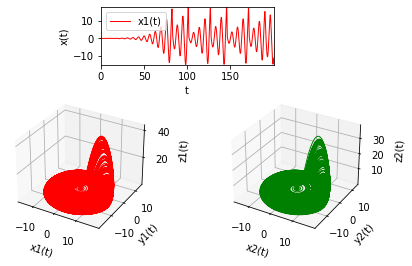

In [8]:
#Now that we have the solution in vectors t,x,y,z is time to plot them.

#We create a figure and 4 axes on it. 3 of the axes are going to be 2D and the fourth one is a 3D plot.
fig = figure()
ax1 = fig.add_axes([0.30, 0.7, 0.4, 0.2])
ax3 = fig.add_axes([0.05, 0.1, 0.4, 0.5],projection='3d')
ax4 = fig.add_axes([0.55, 0.1, 0.4, 0.5],projection='3d')
 

#And we add vectors to each plot
_t = t[:20000] # 200 seconds
_x1 = x1[:20000]
ax1.plot(_t, _x1,color='red',lw=1,label='x1(t)')
ax1.set_xlabel('t')
ax1.set_ylabel('x(t)')
ax1.legend()
ax1.axis((min(_t), max(_t),min(_x1),max(_x1)))
 

# ax1.plot(t, x2,color='green',lw=1,label='x2(t)')
#ax1.set_xlabel('t')
#ax1.set_ylabel('x(t)')
#ax1.legend()
#ax1.axis((min(t),max(t),min(x2),max(x2)))
 
ax4.plot(x2, y2,z2,color='green',lw=1)
ax4.set_xlabel('x2(t)')
ax4.set_ylabel('y2(t)')
ax4.set_zlabel('z2(t)')
 
ax3.plot(x1, y1,z1,color='red',lw=1)
ax3.set_xlabel('x1(t)')
ax3.set_ylabel('y1(t)')
ax3.set_zlabel('z1(t)')
 


# Зависимость x1 и x2

In [9]:
# Функция подобия
def simFn(x1,x2, skew):
    if skew == 0:
        diff_skew = x1 - x2
    else:
        diff_skew = x1[skew:] - x2[:-skew]
    
    diff_skew_avg = np.average(diff_skew*diff_skew)
    
    x1_sq_avg = np.average(x1*x1)
    x2_sq_avg = np.average(x2*x2)
    factor = np.sqrt(x1_sq_avg*x2_sq_avg)
    
    return diff_skew_avg/factor

## Случай $\bf\epsilon = 0.05$

In [10]:
K = 0.05
XYZ_0_05 = orbit_rossler(x1_0, y1_0, z1_0, x2_0, y2_0, z2_0,dt,a,b,c, K, w1,w2, numsteps)
x1 = XYZ_0_05[:,0]
x2 = XYZ_0_05[:,3]

# посмотрим в устоявшемся режиме
x1 = x1[10000:]
x2 = x2[10000:]


График $x2(x1)$

Text(0, 0.5, '$x2(t)$')

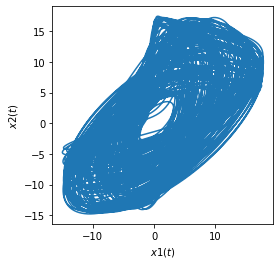

In [11]:
plt.plot(x1,x2)
ax = plt.gca()
ax.set_aspect(1.0)
ax.set_xlabel('$x1(t)$')
ax.set_ylabel('$x2(t)$')

In [12]:
tau = np.arange(0,30,dt)
S = np.array([ simFn(x2, x1, int(_tau/dt)) for _tau in tau ])


Text(0, 0.5, '$S(\\Delta t)$')

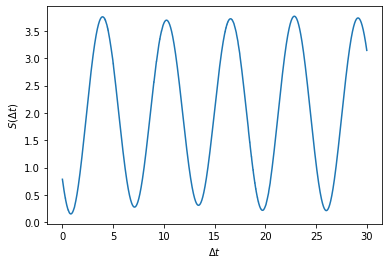

In [13]:
plt.plot(tau, S)
ax = plt.gca()
ax.set_xlabel('$\Delta t$')
ax.set_ylabel('$S(\Delta t)$')

In [14]:
# Минимум S на первых 10 секундах
minskew = np.argmin(S[:1000])

### Взаимный график $x1$ и $x2$ для случая наилучшей синхронизации

Text(0, 0.5, '$x2(t)$')

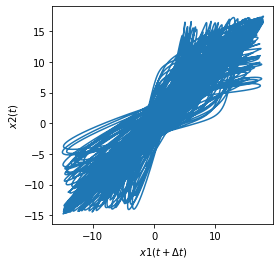

In [15]:
plt.plot(x1[:-minskew], x2[minskew:])
ax = plt.gca()
ax.set_aspect(1.0)
ax.set_xlabel('$x1(t + \Delta t)$')
ax.set_ylabel('$x2(t)$')


# Случай $\bf\epsilon = 0.2$

In [16]:
K = 0.2
XYZ_0_2 = orbit_rossler(x1_0, y1_0, z1_0, x2_0, y2_0, z2_0,dt,a,b,c, K, w1,w2, numsteps)
x1 = XYZ_0_2[:,0]
x2 = XYZ_0_2[:,3]

# посмотрим в устоявшемся режиме
x1 = x1[10000:]
x2 = x2[10000:]

График $x2(x1)$

Text(0, 0.5, '$x2(t)$')

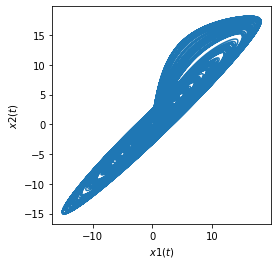

In [17]:
plt.plot(x1,x2)
ax = plt.gca()
ax.set_aspect(1.0)
ax.set_xlabel('$x1(t)$')
ax.set_ylabel('$x2(t)$')

In [18]:
tau = np.arange(0,30,dt)
S = np.array([ simFn(x2,x1,int(_tau/dt)) for _tau in tau ])


Text(0, 0.5, '$S(\\Delta t)$')

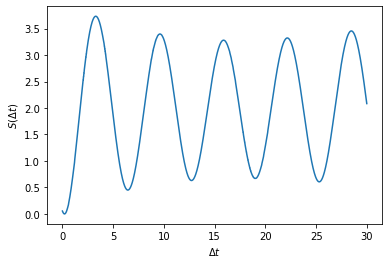

In [19]:
plt.plot(tau, S)
ax = plt.gca()
ax.set_xlabel('$\Delta t$')
ax.set_ylabel('$S(\Delta t)$')

In [20]:
# Минимум S на первых 10 секундах
minskew = np.argmin(S[:1000])

### Взаимный график $x1$ и $x2$ для случая наилучшей синхронизации

Text(0, 0.5, '$x2(t)$')

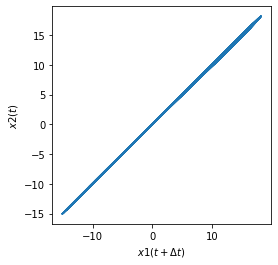

In [21]:
plt.plot(x1[:-minskew], x2[minskew:])
ax = plt.gca()
ax.set_aspect(1.0)
ax.set_xlabel('$x1(t + \Delta t)$')
ax.set_ylabel('$x2(t)$')
